In [3]:
import sys
import os
import matplotlib.pyplot as plt
import pandas as pd
%config InlineBackend.figure_format = 'retina'
import numpy as np

sys.path.append(os.path.abspath(os.path.join('..')))

from src.data_loader import load_book_data
from src.feature_engineering import build_microstructure_features
from src.models.regime_detector import MarketRegimeModel
from pathlib import Path

ROOT_DIR = Path(os.getcwd()).parent 
DATA_PATH = ROOT_DIR / "data" / "book_train.parquet"

df = pd.read_parquet(DATA_PATH)

--- Post-Match Review ---

Total Time Buckets: 3830
Market Average WAP (Benchmark): 1.00005
Dip Snipe Execution WAP:        0.99928
Implementation Shortfall:       -7.68 bps

Action Frequency Breakdown:
action
Rally Wait (Passive)      3645
Dip Snipe (Aggressive)     139
Normal VWAP                 46

Total Regime Switches: 93
Switch Ratio: 2.4% (Ideal is < 5%)


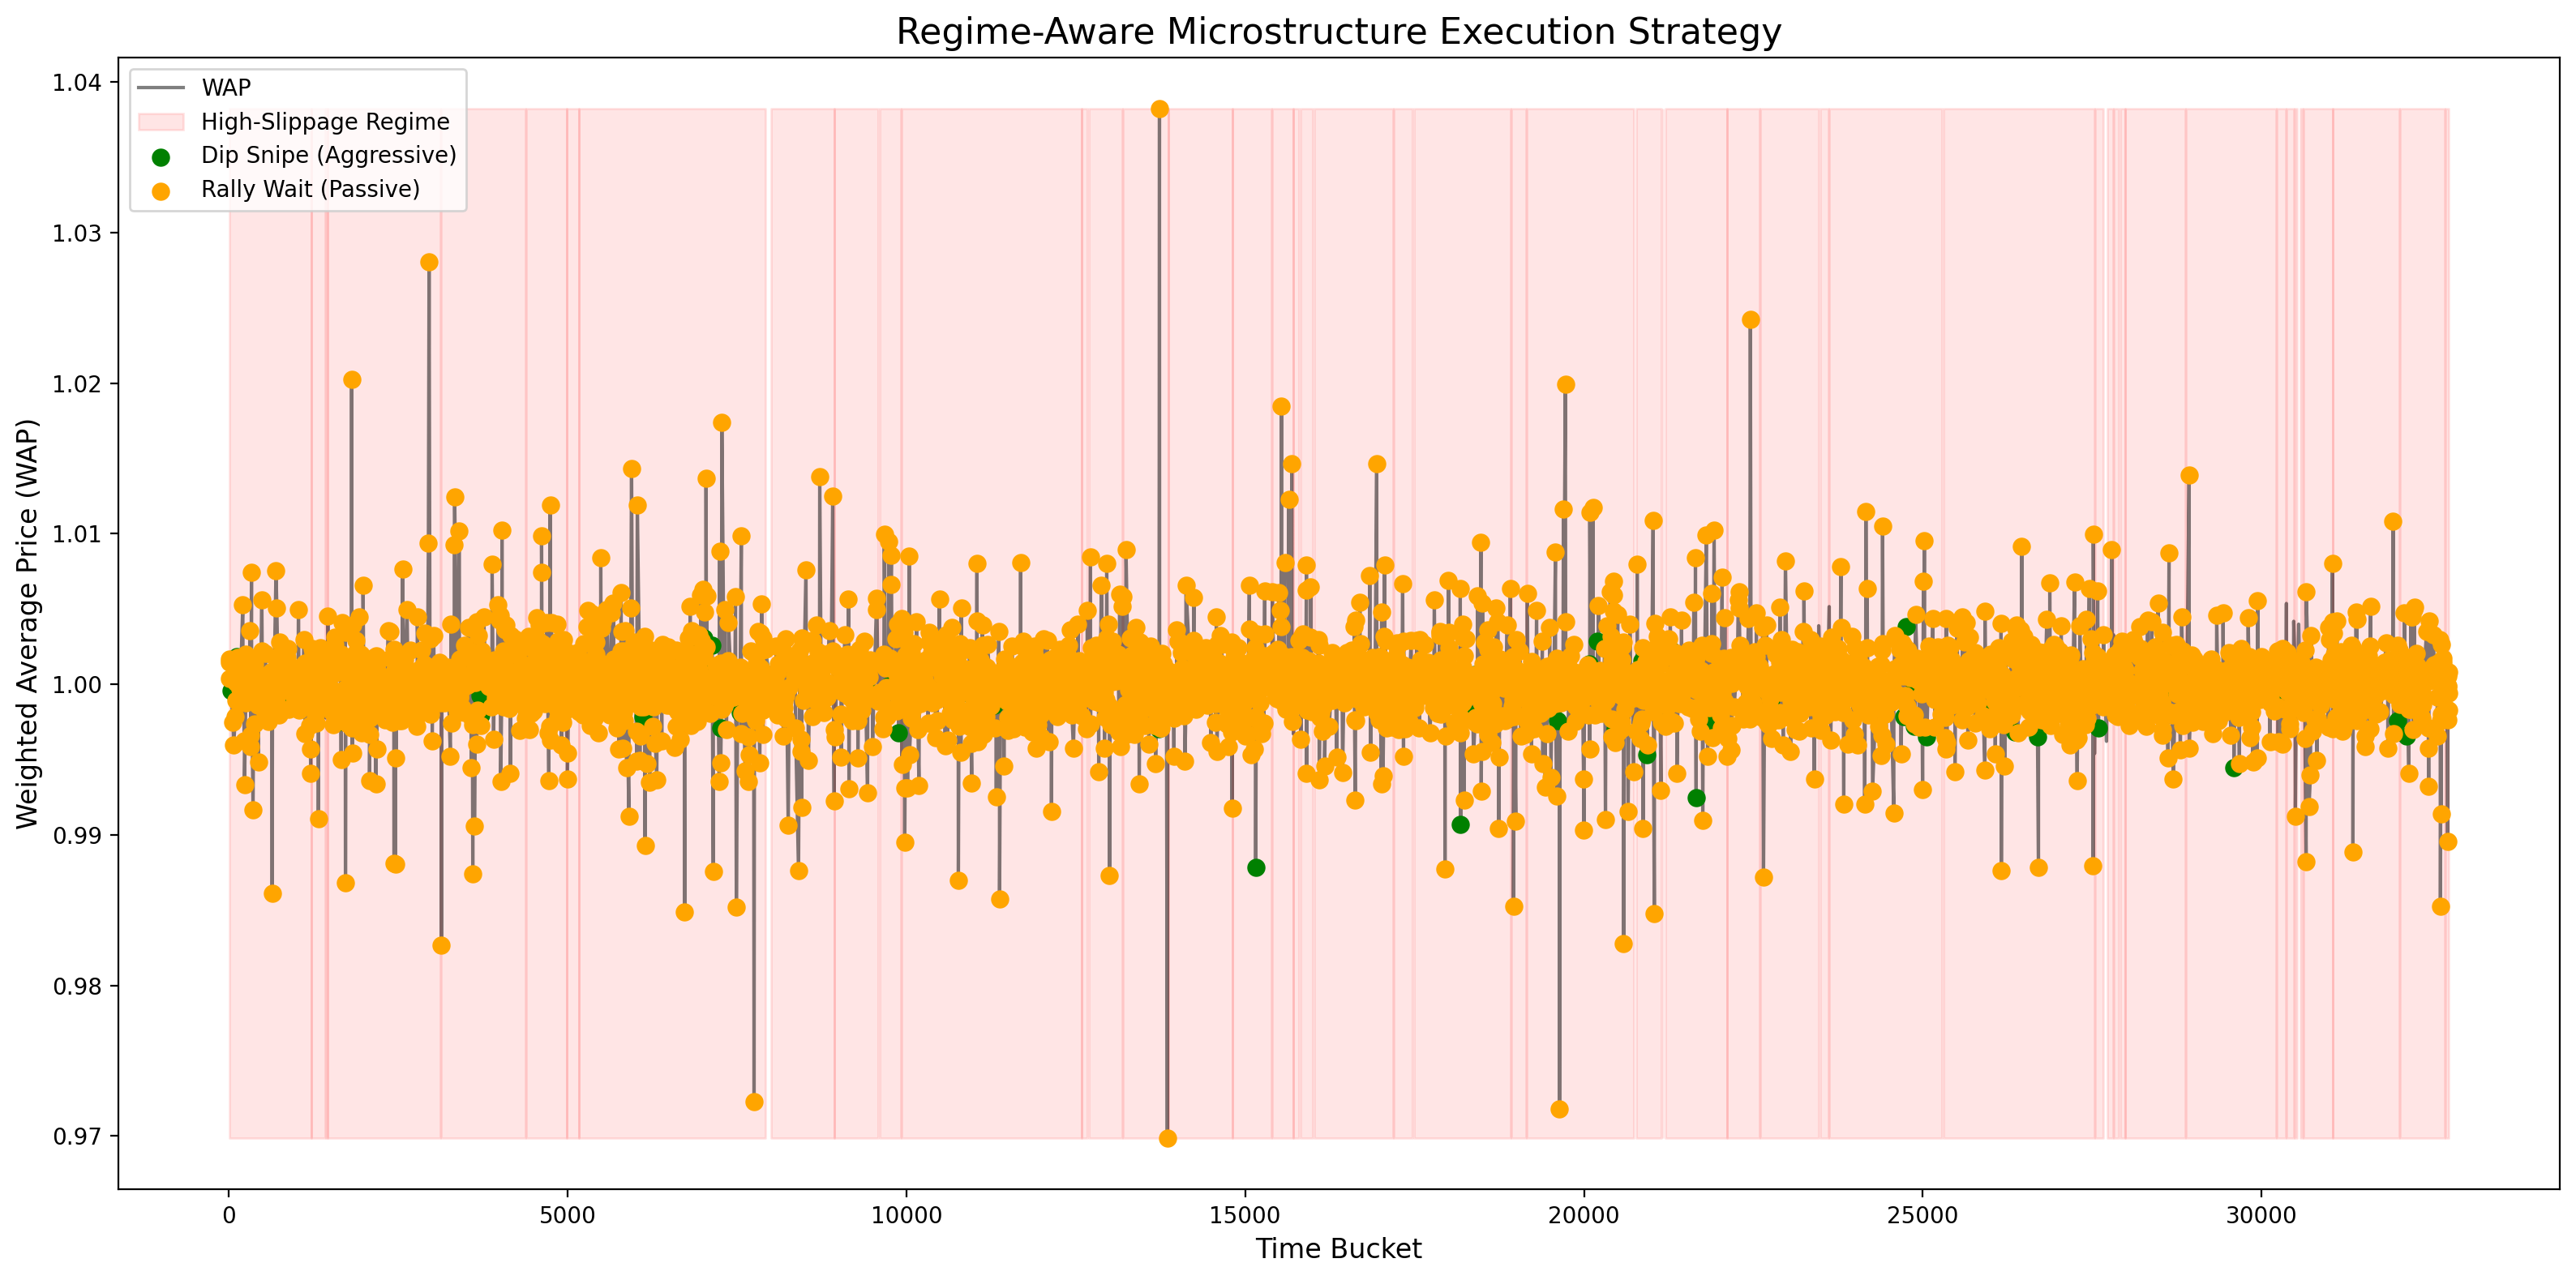

In [4]:
features_df = build_microstructure_features(df)

feature_cols = ['spread_mean', 'obi_std']
regime_model = MarketRegimeModel(n_components=2)
features_df['regime'] = regime_model.fit_predict(features_df, feature_cols)

crash_state = regime_model.crash_state
features_df['action'] = 'Normal VWAP'

dip_condition = (features_df['regime'] == crash_state) & (features_df['obi_mean'] < -0.2)
rally_condition = (features_df['regime'] == crash_state) & (features_df['obi_mean'] >= -0.2)

features_df.loc[dip_condition, 'action'] = 'Dip Snipe (Aggressive)'
features_df.loc[rally_condition, 'action'] = 'Rally Wait (Passive)'

print("--- Post-Match Review ---\n")

market_wap = features_df['wap_mean'].mean()

snipe_trades = features_df[features_df['action'] == 'Dip Snipe (Aggressive)']

if not snipe_trades.empty:
    snipe_wap = snipe_trades['wap_mean'].mean()
    slippage_bps = ((snipe_wap - market_wap) / market_wap) * 10000
else:
    snipe_wap = 0
    slippage_bps = 0

print(f"Total Time Buckets: {len(features_df)}")
print(f"Market Average WAP (Benchmark): {market_wap:.5f}")
print(f"Dip Snipe Execution WAP:        {snipe_wap:.5f}")
print(f"Implementation Shortfall:       {slippage_bps:.2f} bps\n")

print("Action Frequency Breakdown:")
print(features_df['action'].value_counts().to_string())

regime_switches = (features_df['regime'] != features_df['regime'].shift(1)).sum()
print(f"\nTotal Regime Switches: {regime_switches}")
print(f"Switch Ratio: {(regime_switches/len(features_df))*100:.1f}% (Ideal is < 5%)")

#viz
plt.figure(figsize=(16, 8))

plt.plot(features_df.index, features_df['wap_mean'], color='black', alpha=0.5, label='WAP')

crash_mask = features_df['regime'] == crash_state
plt.fill_between(features_df.index, features_df['wap_mean'].min(), features_df['wap_mean'].max(), 
                 where=crash_mask, color='red', alpha=0.1, label='High-Slippage Regime')


dips = features_df[features_df['action'] == 'Dip Snipe (Aggressive)']
plt.scatter(dips.index, dips['wap_mean'], color='green', s=50, label='Dip Snipe (Aggressive)', zorder=5)

rallies = features_df[features_df['action'] == 'Rally Wait (Passive)']
plt.scatter(rallies.index, rallies['wap_mean'], color='orange', s=50, label='Rally Wait (Passive)', zorder=5)

plt.title("Regime-Aware Microstructure Execution Strategy", fontsize=16)
plt.xlabel("Time Bucket", fontsize=12)
plt.ylabel("Weighted Average Price (WAP)", fontsize=12)
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()


In [5]:
from sklearn.model_selection import TimeSeriesSplit
from src.evaluation import ExecutionEvaluator

tscv = TimeSeriesSplit(n_splits=2)
train_indices, test_indices = list(tscv.split(features_df))[0]

train_df = features_df.iloc[train_indices].copy()
test_df = features_df.iloc[test_indices].copy()

feature_cols = ['spread_mean', 'obi_std']
regime_model = MarketRegimeModel(n_components=2)
regime_model.fit_predict(train_df, feature_cols)

test_df['regime'] = regime_model.predict(test_df[feature_cols].values)

crash_state = regime_model.crash_state
test_df['action'] = 'Normal VWAP'
dip_condition = (test_df['regime'] == crash_state) & (test_df['obi_mean'] < -0.2)
test_df.loc[dip_condition, 'action'] = 'Dip Snipe (Aggressive)'

evaluator = ExecutionEvaluator()
stats = evaluator.get_diagnostics(test_df)

print(f"--- Out-of-Sample Performance ---")
print(f"Implementation Shortfall: {stats['is_bps']:.2f} bps")
print(f"Hit Ratio (30s Alpha):    {stats['hit_ratio']*100:.1f}%")
print(f"Regime Switch Ratio:      {stats['switch_ratio']*100:.2f}%")

--- Out-of-Sample Performance ---
Implementation Shortfall: -9.15 bps
Hit Ratio (30s Alpha):    54.3%
Regime Switch Ratio:      1.72%
